# Import Packages

In [1]:
import os
import sys

# For Jupyter notebooks, get the current directory
current_dir = os.getcwd()
print(current_dir)

# Get the directory containing 'EvDemandModel'
parent_dir = os.path.dirname(os.path.dirname(current_dir))
print(parent_dir)

# Appending the parent directory to the Python path
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Geocoding
import geopandas as gpd
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

from EvDemandModel.Preprocessing import Preprocess
from EvDemandModel.Calibration import CalculateCalibrationFactors
from EvDemandModel.Utils import CalibrationFactorApplier
from EvDemandModel.OnPlotParking import CalculateProportionOfVehiclesWithOnPlotParking, CalculateProportionOfEVsWithOnPlotParking
from EvDemandModel.SubstationMapping import LoadDistributionSubstationData, SubstationDataMapper

from importlib import reload


/Users/isaacflower/Library/CloudStorage/OneDrive-UniversityofBath/Documents/PhD/EV Modelling/net-zero-energy-systems/EvDemandModel/Dev
/Users/isaacflower/Library/CloudStorage/OneDrive-UniversityofBath/Documents/PhD/EV Modelling/net-zero-energy-systems


# Convenience Functions

In [2]:
def calculate_opp_proportions(preprocessed_data, quarter):
    opp_props = {}
    opp_props['vehicle'] = CalculateProportionOfVehiclesWithOnPlotParking.calculate(
        preprocessed_data['accommodation_type_2021'],
        preprocessed_data['house_2021'],
        preprocessed_data['car_van_2021'],
    )
    
    for vehicle_type in ['bev', 'phev']:
        opp_props[f'{vehicle_type}'] = CalculateProportionOfEVsWithOnPlotParking.calculate(
            opp_props['vehicle'],
            preprocessed_data[f'vehicle_registrations_i'],
            preprocessed_data[f'{vehicle_type}_registrations_i'],
            quarter
        )
    return opp_props

def apply_calibration_factors(preprocessed_data, calibration_factors, quarter):
    adoptions = {}
    for vehicle_type in ['vehicle', 'bev', 'phev']:
        adoptions[f'{vehicle_type}'] = CalibrationFactorApplier.calibrate(
            preprocessed_data[f'{vehicle_type}_registrations_i'],
            calibration_factors,
            quarter
        )
    return adoptions

# Data Pre-processing

In [3]:
preprocessed_data = Preprocess.preprocess()

CarVan2011DataPreprocessor pre-processing complete
CarVan2021DataPreprocessor pre-processing complete
VehicleRegistrationsDataPreprocessor pre-processing complete
EVRegistrationsDataPreprocessor pre-processing complete
EVRegistrationsDataPreprocessor pre-processing complete
HouseDataPreprocessor pre-processing complete
AccommodationTypeDataPreprocessor pre-processing complete
LSOABoundaryDataPreprocessor pre-processing complete
Interpolating Data...
Interpolating Data...
Interpolating Data...


In [354]:
preprocessed_data.keys()

dict_keys(['car_van_2011', 'car_van_2021', 'vehicle_registrations', 'bev_registrations', 'phev_registrations', 'house_2021', 'accommodation_type_2021', 'lsoa_boundaries', 'vehicle_registrations_i', 'bev_registrations_i', 'phev_registrations_i'])

In [351]:
preprocessed_data['car_van_2011']

,LSOA11NM,cars,households,households_without_cars
LSOA11CD,,,,
E01000001,City of London 001A,452,876,519
E01000002,City of London 001B,441,830,481
E01000003,City of London 001C,180,817,655
E01000005,City of London 001E,124,467,356
E01000006,Barking and Dagenham 016A,496,543,186
...,...,...,...,...
W01001951,Cardiff 049E,535,548,135
W01001953,Cardiff 005G,704,643,177
W01001954,Cardiff 006F,1001,637,73


# Filter Data by LAD

In [4]:
def filter_data_by_lad(data: dict, lad: str) -> dict:
    lad_lsoas = data['car_van_2011'][data['car_van_2011']['LSOA11NM'].str[:-5] == lad].index.values
    result = {}
    for key, df in data.items():
        result[key] = df.loc[lad_lsoas]
    return result

In [5]:
lad = 'Bath and North East Somerset'
lad_preprocessed_data = filter_data_by_lad(preprocessed_data, lad)

# Calculate Calibration Factors

In [6]:
calibration_factors = CalculateCalibrationFactors.calculate(
    lad_preprocessed_data['car_van_2011'],
    lad_preprocessed_data['car_van_2021'],
    lad_preprocessed_data['vehicle_registrations']
)

Calculating relative errors...
Generating calibration factor samples...


# Create Adoption Dataset

In [7]:
opp_proportions = calculate_opp_proportions(lad_preprocessed_data, '2023 Q1')

adoptions = apply_calibration_factors(lad_preprocessed_data, calibration_factors, '2023 Q1')

bev_with_opp = adoptions['bev'].mul(opp_proportions['bev']).round(0)
phev_with_opp = adoptions['phev'].mul(opp_proportions['phev']).round(0)

data = {
    'vehicles': adoptions['vehicle'], 
    'bevs': adoptions['bev'],
    'phevs': adoptions['phev'],
    'bevsWithOnPlotParking': bev_with_opp,
    'phevsWithOnPlotParking': phev_with_opp
}

# Load Distribution Substation Data

In [8]:
ds_data = LoadDistributionSubstationData.load_data()

ds_data = ds_data.set_index('Substation Number', drop=False)

# Drop Duplicates
ds_data = ds_data.loc[~ds_data.index.duplicated(keep='first')]

# Filter Substation Data by LAD

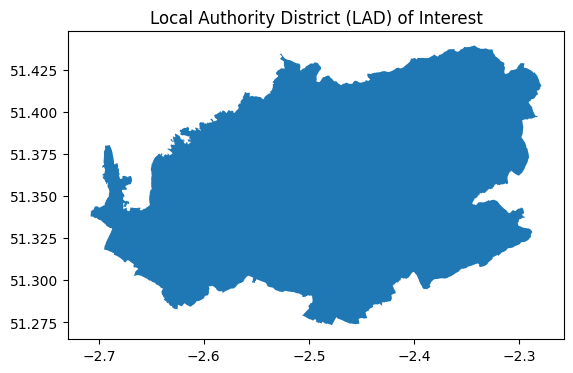

In [9]:
def return_lad_geo(lad):
    return ox.geocoder.geocode_to_gdf(lad, which_result=1)

return_lad_geo(lad).plot()
plt.title('Local Authority District (LAD) of Interest')
plt.show()

In [10]:
def filter_ds_by_lad(ds_data, lad_geo):
    return ds_data.loc[ds_data.Location.within(lad_geo.geometry.values[0])]

lad_geo = return_lad_geo(lad)
ds_lad = filter_ds_by_lad(ds_data, lad_geo)
ds_lad.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers,Location
Substation Number,,,,,,,,,,,,,,,,,,,,,
110055,110055,"POLYGON ((-2.46167 51.39973, -2.46174 51.39976...",33528,19,Saltford Od,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Saltford Od,ST682140670940,-2.45840,51.401900,302.0,211.0,500.0,3.0,130.0,POINT (-2.45840 51.40190)
110060,110060,"POLYGON ((-2.49497 51.40702, -2.49581 51.40727...",33532,19,Keelings Ss,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Keelings Ss,ST658270679910,-2.49280,51.409800,140.0,68.0,315.0,3.0,113.0,POINT (-2.49280 51.40980)
110066,110066,"POLYGON ((-2.49769 51.40349, -2.49779 51.40351...",33542,19,Burnett Rd K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Burnett Rd K,ST658460673840,-2.49242,51.404389,117.0,55.0,300.0,3.0,94.0,POINT (-2.49242 51.40439)
110165,110165,"POLYGON ((-2.51360 51.41669, -2.51393 51.41716...",33683,19,Stockwood Vale Od,15049,Keynsham West,128239,Feeder Road 33kv,130,...,Stockwood Vale Od,ST644800689440,-2.51220,51.418300,89.0,44.0,500.0,0.0,47.0,POINT (-2.51220 51.41830)
110182,110182,"POLYGON ((-2.46675 51.40341, -2.46675 51.40341...",33715,19,Grange Road K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grange Road K Saltford,ST677120673570,-2.46560,51.404300,79.0,47.0,315.0,4.0,54.0,POINT (-2.46560 51.40430)


In [11]:
len(ds_lad.index.values)

1759

In [12]:
ds_lad['Customers'].isna().sum()

651

# Mapp LSOA Data to Distribution Substations

In [98]:
substation_data_mapper = SubstationDataMapper(
    ds_data=ds_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

ds_vehicle_estimates = substation_data_mapper.map_to_substation(data=data)

In [99]:
ds_vehicle_estimates['evs'] = ds_vehicle_estimates['bevs'] + ds_vehicle_estimates['phevs']
ds_vehicle_estimates['evsWithOnPlotParking'] = ds_vehicle_estimates['bevsWithOnPlotParking'] + ds_vehicle_estimates['phevsWithOnPlotParking']

In [15]:
ds_vehicle_estimates['evs']

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
Quantile,,,,,,,,,,,,,,,,,,,,,
0%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96%,11,8,5,5,5,8,10,12,9,9,...,0,0,0,0,0,0,0,0,0,0
97%,11,8,6,5,6,8,10,12,10,10,...,0,0,0,0,0,0,0,0,0,0
98%,11,8,6,6,6,8,11,13,10,10,...,0,0,0,0,0,0,0,0,0,0


/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_76937/3140424418.py:4: RuntimeWarning: invalid value encountered in cast
  y = np.array(ds_lad['EV Chargers'].values).astype(int)


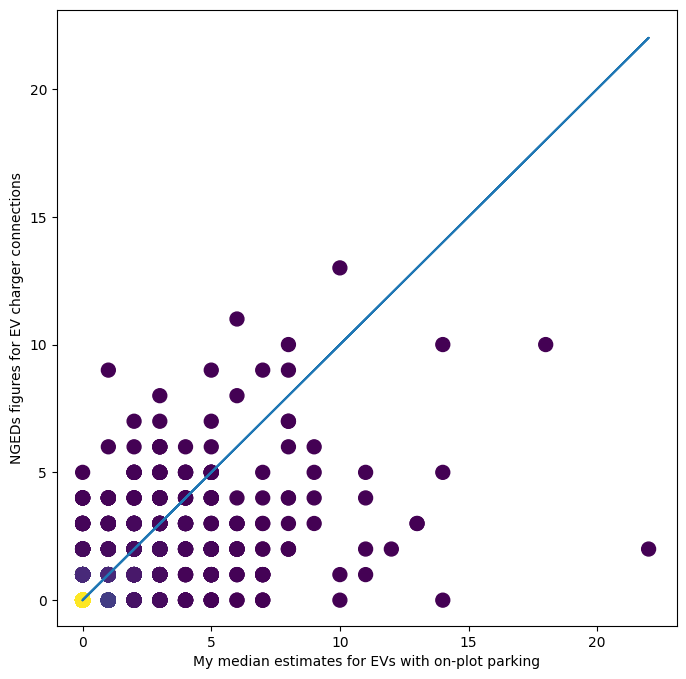

In [16]:
from scipy.stats import gaussian_kde

x = ds_vehicle_estimates['evsWithOnPlotParking'].loc['50%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My median estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_76937/2533162526.py:2: RuntimeWarning: invalid value encountered in cast
  y = np.array(ds_lad['EV Chargers'].values).astype(int)


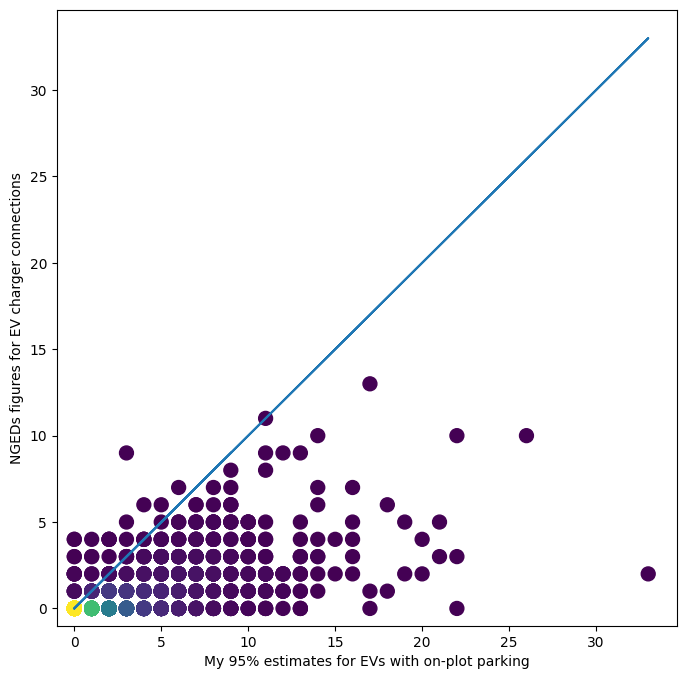

In [17]:
x = ds_vehicle_estimates['evsWithOnPlotParking'].loc['95%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My 95% estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_76937/2416779907.py:2: RuntimeWarning: invalid value encountered in cast
  y = np.array(ds_lad['EV Chargers'].values).astype(int)


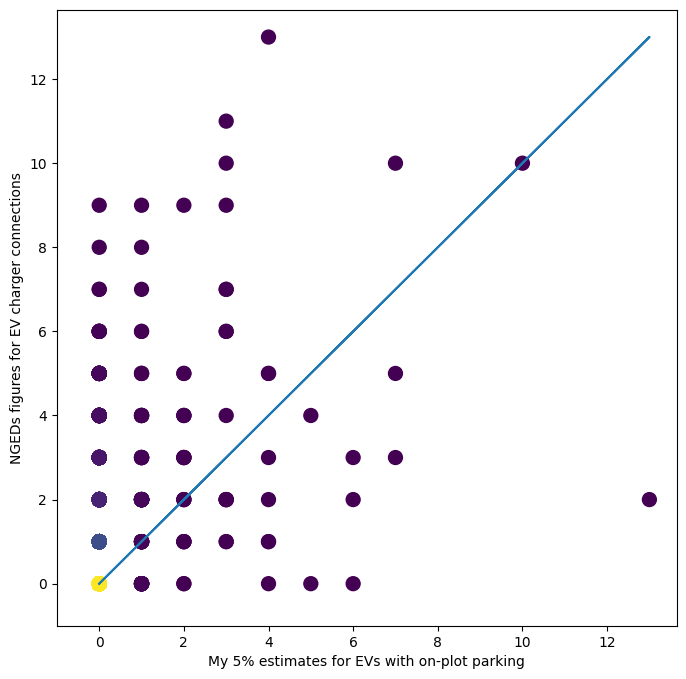

In [319]:
x = ds_vehicle_estimates['evsWithOnPlotParking'].loc['5%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My 5% estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

# Evaluate Predictive Accuracy for Different Percentile Ranges

In [80]:
def evaluate_predctions(predictions, true_values, lower, upper):
    non_nan_idx = true_values[~true_values.isna()].index
    evaluation = ((true_values.loc[non_nan_idx] >= predictions[non_nan_idx].loc[lower]) & (true_values.loc[non_nan_idx] <= predictions[non_nan_idx].loc[upper]))
    hits = sum(evaluation)
    total = len(evaluation)
    if total == 0:
        score = hits/np.nan
    else:
        score = hits/total
    return hits, total, score

In [81]:
hits, total, score = evaluate_predctions(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'], '0%', '100%')
print(f'Hits: {hits}')
print(f'Total: {total}')
print(f'Score: {round(score, 3)}')

Hits: 1093
Total: 1108
Score: 0.986


# Errors

In [49]:
def calculate_errors_by_percentile(predictions, true_values):
    percentiles = [f"{i}%" for i in range(0, 101, 1)]
    errors_df = pd.DataFrame(index=percentiles, columns=predictions.columns)
    for percentile in percentiles:
        errors_df.loc[percentile] = (predictions.loc[percentile] - true_values)
    errors_df = errors_df.dropna(axis=1).astype(int)
    return errors_df

In [50]:
errors_df = calculate_errors_by_percentile(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'])
errors_df

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,181944,181983,181984,182048,182058,182059,182066,182111,182470,182977
0%,-3,-3,-3,0,-4,-3,-4,-1,-4,-3,...,0,0,0,0,0,-1,-3,-3,-3,0
1%,-3,-3,-3,0,-4,-3,-4,-1,-4,-3,...,0,0,0,0,0,-1,-3,-3,-3,0
2%,-3,-3,-3,0,-4,-3,-4,-1,-4,-3,...,0,0,0,0,0,-1,-3,-3,-3,0
3%,-3,-3,-3,0,-4,-3,-4,-1,-4,-3,...,0,0,0,0,0,-1,-3,-3,-3,0
4%,-3,-3,-3,0,-4,-3,-4,0,-4,-3,...,0,0,0,0,0,-1,-3,-3,-3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96%,7,3,2,5,1,5,6,11,4,6,...,3,2,2,2,3,2,3,2,5,3
97%,7,4,3,5,1,5,6,11,5,6,...,4,3,2,2,3,2,4,3,6,3
98%,8,5,4,6,2,5,6,11,6,7,...,4,3,2,3,3,3,5,3,6,3
99%,8,5,4,6,3,7,7,13,6,8,...,5,3,3,3,5,4,5,4,7,4


In [89]:
MAE_df = errors_df.abs()
MAE_df

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,181944,181983,181984,182048,182058,182059,182066,182111,182470,182977
0%,3,3,3,0,4,3,4,1,4,3,...,0,0,0,0,0,1,3,3,3,0
1%,3,3,3,0,4,3,4,1,4,3,...,0,0,0,0,0,1,3,3,3,0
2%,3,3,3,0,4,3,4,1,4,3,...,0,0,0,0,0,1,3,3,3,0
3%,3,3,3,0,4,3,4,1,4,3,...,0,0,0,0,0,1,3,3,3,0
4%,3,3,3,0,4,3,4,0,4,3,...,0,0,0,0,0,1,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96%,7,3,2,5,1,5,6,11,4,6,...,3,2,2,2,3,2,3,2,5,3
97%,7,4,3,5,1,5,6,11,5,6,...,4,3,2,2,3,2,4,3,6,3
98%,8,5,4,6,2,5,6,11,6,7,...,4,3,2,3,3,3,5,3,6,3
99%,8,5,4,6,3,7,7,13,6,8,...,5,3,3,3,5,4,5,4,7,4


In [90]:
MAE_df.mean(axis=1)

0%      1.154332
1%      1.122744
2%      1.111913
3%      1.093863
4%      1.081227
          ...   
96%     3.876354
97%     4.168773
98%     4.541516
99%     5.185921
100%    7.635379
Length: 101, dtype: float64

<Axes: >

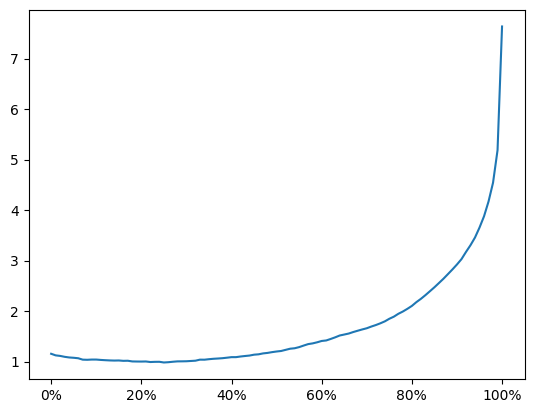

In [91]:
MAE_df.mean(axis=1).plot()

In [52]:
# Proportion of correct estimates by percentile
errors_df[errors_df==0].replace(0, 1).sum(axis=1)/len(errors_df.columns)

0%      0.487365
1%      0.490975
2%      0.489170
3%      0.493682
4%      0.488267
          ...   
96%     0.066787
97%     0.058664
98%     0.052347
99%     0.040614
100%    0.029783
Length: 101, dtype: float64

(0.0, 1.0)

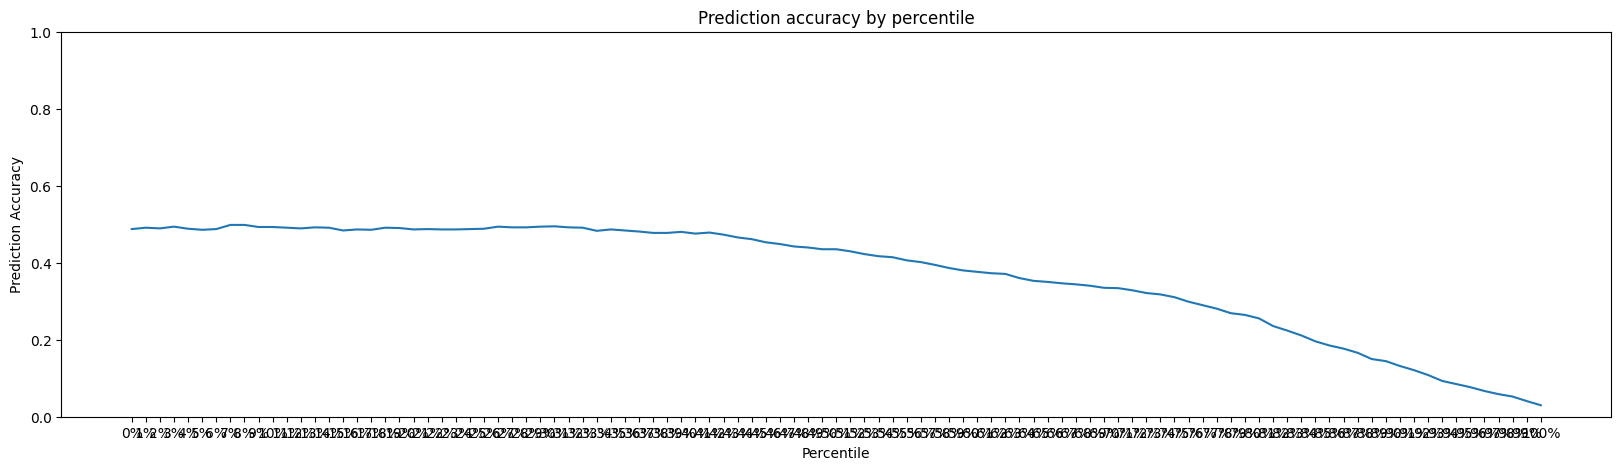

In [55]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(errors_df[errors_df==0].replace(0, 1).sum(axis=1)/len(errors_df.columns.values))
plt.title('Prediction accuracy by percentile')
plt.ylabel('Prediction Accuracy')
plt.xlabel('Percentile')
plt.ylim(0, 1)

In [59]:
# This function looks for exact matches
# This is different to the previous function which looks for if the true value lies within the prediction range. 
(errors_df==0).sum().gt(0).sum()/len(errors_df.columns)

0.970216606498195

# Ability to predict specific EV charger numbers

In [86]:
def calculate_predictive_accuracy_by_n_chargers(predictions, true_values, lower, upper):
    scores = pd.DataFrame(index=np.arange(0, 20), columns=['n_chargers', 'hits', 'total', 'accuracy'])
    for n in np.arange(0, 20):
        idx = true_values[true_values == n].index
        hits, total, score = evaluate_predctions(predictions[idx], true_values.loc[idx], lower, upper)
        scores.loc[n, 'n_chargers'] = n
        scores.loc[n, 'hits'] = hits
        scores.loc[n, 'total'] = total
        scores.loc[n, 'accuracy'] = round(score, 3)
        
    return scores

In [87]:
calculate_predictive_accuracy_by_n_chargers(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'], '0%', '100%')

,n_chargers,hits,total,accuracy
0,0,538,541,0.994
1,1,252,253,0.996
2,2,126,132,0.955
3,3,80,81,0.988
4,4,44,47,0.936
5,5,28,28,1.0
6,6,10,10,1.0
7,7,5,5,1.0
8,8,2,2,1.0
9,9,3,4,0.75


In [88]:
calculate_predictive_accuracy_by_n_chargers(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'], '25%', '75%')

,n_chargers,hits,total,accuracy
0,0,470,541,0.869
1,1,165,253,0.652
2,2,83,132,0.629
3,3,49,81,0.605
4,4,24,47,0.511
5,5,17,28,0.607
6,6,4,10,0.4
7,7,3,5,0.6
8,8,1,2,0.5
9,9,2,4,0.5


# Low Fidelity Approach

### Primary substation data

In [92]:
ps = gpd.read_file('../Data/DistributionNetwork/south-west-primary.gpkg').to_crs('EPSG:4326')
ps.head()

,PRIM_NRID_NAME,PRIM_NRID,NR,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,geometry
0,Cheddar,15094,181345,Churchill Bsp 132kv,85,Bridgwater S.G.P.,135,"MULTIPOLYGON (((-2.78699 51.28445, -2.78796 51..."
1,Feeder Road B,15058,113374,Feeder Road 33kv,128239,Iron Acton S.G.P.,130,"MULTIPOLYGON (((-2.55670 51.44990, -2.55654 51..."
2,Foxhills,15078,162344,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.41861 51.30932, -2.41697 51..."
3,Paulton,15072,161315,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49676 51.30564, -2.49676 51..."
4,Wadebridge,15276,437210,St Tudy Bsp,24,Indian Queens S.G.P.,138,"MULTIPOLYGON (((-4.83442 50.51716, -4.83423 50..."


In [93]:
ps_lad = ps[ps['PRIM_NRID'].isin(ds_lad['PRIM_NRID'].unique())].set_index('PRIM_NRID')
ps_lad['Substation Number'] = ps_lad.index
ps_lad['Customers'] = ds_lad.groupby('PRIM_NRID')['Customers'].sum().astype(int)
ps_lad

,PRIM_NRID_NAME,NR,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,geometry,Substation Number,Customers
PRIM_NRID,,,,,,,,,
15078,Foxhills,162344,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.41861 51.30932, -2.41697 51...",15078,4316
15072,Paulton,161315,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49676 51.30564, -2.49676 51...",15072,2809
15076,Newbury,161701,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.39720 51.27170, -2.39254 51...",15076,6
15066,Twerton,160390,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.40490 51.36898, -2.40574 51...",15066,6088
15064,Entry Hill,160355,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.32577 51.34754, -2.33497 51...",15064,7183
15062,Park Street,160060,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.36149 51.38446, -2.36114 51...",15062,6856
15080,Combe Park,164016,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.45925 51.41659, -2.45912 51...",15080,4875
15074,High Littleton,161532,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.46296 51.31941, -2.46316 51...",15074,3659
15068,Midsomer Norton,160423,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49827 51.30843, -2.49827 51...",15068,8115


In [297]:
primary_substation_data_mapper = SubstationDataMapper(
    ds_data=ps_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

ps_vehicle_estimates_quantiles = primary_substation_data_mapper.map_to_substation(data=data)

In [298]:
ps_vehicle_estimates_quantiles['bevsWithOnPlotParking']

,15078,15072,15076,15066,15064,15062,15080,15074,15068,15085,15095,15049,15079,15042,15061,15047,302497,15065,15093,15067
Quantile,,,,,,,,,,,,,,,,,,,,
0%,23,40,0,27,117,105,31,54,75,0,26,71,28,101,54,33,119,122,25,10
1%,25,45,0,31,125,111,36,59,79,0,28,74,31,103,57,37,124,128,29,13
2%,26,46,0,32,126,113,37,60,80,0,29,76,31,105,58,38,125,130,31,14
3%,27,47,0,33,128,113,38,61,81,0,30,77,32,106,59,39,126,132,31,14
4%,27,48,0,33,129,114,38,62,81,0,30,78,32,107,59,39,127,133,32,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96%,39,63,0,46,153,137,56,79,94,1,42,96,45,126,75,57,155,157,49,27
97%,40,64,0,47,154,138,56,80,95,1,43,96,45,126,76,57,156,158,49,28
98%,40,65,0,47,155,140,57,81,95,1,44,97,45,128,77,58,157,159,50,28


In [293]:
# Without Binomial Process for Distributing EVs from PS to DS
def make_ds_estimates_from_ps(ps_estimates, ps_data, ds_data):
    percentiles = [f"{i}%" for i in range(0, 101, 1)]

    empty_df = pd.DataFrame(index=percentiles, columns=ds_lad.index)

    lf_estimates_bevs = empty_df
    lf_estimates_phevs = empty_df
    lf_estimates_bevs_opp = empty_df
    lf_estimates_phevs_opp = empty_df

    for ps in ps_data.index:
        prop = ds_data[ds_data['PRIM_NRID'] == ps]['Customers']/ps_data.loc[ps, 'Customers']
        for ds in ds_data[ds_data['PRIM_NRID'] == ps].index.values:
            lf_estimates_bevs[ds] = round(prop.loc[ds] * ps_estimates['bevs'][ps]).fillna(0).astype(int)
            lf_estimates_phevs[ds] = round(prop.loc[ds] * ps_estimates['phevs'][ps]).fillna(0).astype(int)
            lf_estimates_bevs_opp[ds] = round(prop.loc[ds] * ps_estimates['bevsWithOnPlotParking'][ps]).fillna(0).astype(int)
            lf_estimates_phevs_opp[ds] = round(prop.loc[ds] * ps_estimates['bevsWithOnPlotParking'][ps]).fillna(0).astype(int)

    lf_estimates = {
        'bevs': lf_estimates_bevs,
        'phevs': lf_estimates_phevs,
        'bevsWithOnPlotParking': lf_estimates_bevs_opp,
        'phevsWithOnPlotParking': lf_estimates_phevs_opp,
        'evs': lf_estimates_bevs + lf_estimates_phevs,
        'evsWithOnPlotParking': lf_estimates_bevs_opp + lf_estimates_phevs_opp
    }
    return lf_estimates

In [321]:
# Very Low Fidelity
ds_vehicle_estimates_vlf = make_ds_estimates_from_ps(ps_vehicle_estimates_quantiles, ps_lad, ds_lad) 

In [322]:
ds_vehicle_estimates_vlf['evsWithOnPlotParking']

Substation Number,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0%,4,4,4,2,2,2,6,6,4,6,...,0,0,0,0,0,0,0,0,0,0
1%,4,4,4,2,2,2,6,6,4,6,...,0,0,0,0,0,0,0,0,0,0
2%,4,4,4,2,2,2,6,6,4,6,...,0,0,0,0,0,0,0,0,0,0
3%,4,4,4,2,2,2,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
4%,6,4,4,2,2,2,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96%,6,6,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
97%,6,6,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
98%,6,6,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
99%,6,6,4,2,2,4,8,8,4,10,...,0,0,0,0,0,0,0,0,0,0


In [273]:
from scipy.stats import binom

class PrimarySubstationDataMapper:
    PERCENTILE_STEP = 1
    QUANTILE_STEP = PERCENTILE_STEP/100

    def __init__(self, ps_data: pd.DataFrame, ds_data: pd.DataFrame, lsoa_boundaries: gpd.GeoDataFrame) -> None:
        self.ps_data = ps_data.set_index('Substation Number')
        self.ds_data = ds_data.set_index('Substation Number')
        self.lsoa_boundaries = lsoa_boundaries
    
    def map_ps_to_ds(self, data: dict) -> dict:
        mapped_data = {key: pd.DataFrame(index=np.arange(0, 1.01, self.QUANTILE_STEP), columns=self.ds_data.index.values) for key in data}
        for key in data:
            mapped_key_data = pd.DataFrame(index=range(0, len(data[key])), columns=self.ds_data.index.values, data=0)
            for ps in self.ps_data.index:
                child_ds = self.ds_data[self.ds_data['PRIM_NRID'] == ps].index.values
                self._allocate_data_from_ps_to_ds(data[key], mapped_key_data, ps, child_ds)
            mapped_data[key] = self._calculate_quantiles(df=mapped_key_data)
            mapped_data['evs'] = mapped_data['bevs'] + mapped_data['phevs']
            mapped_data['evsWithOnPlotParking'] = mapped_data['bevsWithOnPlotParking'] + mapped_data['phevsWithOnPlotParking']
        return mapped_data

    def map_lsoa_to_ps(self, data: dict) -> dict:
        mapped_data = {key: pd.DataFrame(index=np.arange(0, 1001, 1), columns=self.ps_data.index.values) for key in data}
        lad_lsoas = self.lsoa_boundaries.index.values
        for key in data:
            mapped_key_data = pd.DataFrame(index=range(0, len(data[key])), columns=self.ps_data.index.values, data=0)
            for lsoa in lad_lsoas:
                child_ps, intersections = self._find_child_ps(lsoa)
                self._allocate_data_from_lsoa_to_ps(data[key], mapped_key_data, lsoa, child_ps, intersections)
            mapped_data[key] = mapped_key_data
        return mapped_data

    def _find_child_ps(self, lsoa: str):
        intersections = self.ps_data.geometry.intersection(self.lsoa_boundaries.loc[lsoa].geometry)
        pip_mask = ~intersections.is_empty
        child_ps = self.ps_data[pip_mask].index.values
        return child_ps, intersections
    
    def _allocate_data_from_lsoa_to_ps(self, data: pd.DataFrame, mapped_key_data: pd.DataFrame, lsoa:str, child_ps: list, intersections):
        prop_customers = self._calculate_proportion_of_substation_customers_in_lsoa(child_ps, intersections)
        for ps in child_ps:
            n_values = np.maximum(data[lsoa].fillna(0).astype(int), 0)
            p = np.clip(prop_customers.loc[ps], 0, 1)
            samples = binom.rvs(n=n_values, p=p)
            mapped_key_data[ps] += samples
    
    def _allocate_data_from_ps_to_ds(self, data: pd.DataFrame, mapped_key_data: pd.DataFrame, ps: int, child_ds: list):
        prop_customers = (self.ds_data.loc[child_ds, 'Customers']/self.ps_data.loc[ps, 'Customers']).fillna(0)
        for ds in child_ds:
            n_values = np.maximum(data[ps].fillna(0).astype(int), 0)
            p = np.clip(prop_customers.loc[ds], 0, 1)
            samples = binom.rvs(n=n_values, p=p)
            mapped_key_data[ds] += samples
    
    def _calculate_proportion_of_substation_customers_in_lsoa(self, child_ps: list, intersections):
        intersection_areas = intersections.loc[child_ps].area
        substation_areas = self.ps_data.loc[child_ps].geometry.area
        relative_intersections = intersection_areas / substation_areas
        ps_customers_in_lsoa = relative_intersections * self.ps_data.loc[child_ps, 'Customers'].fillna(0)
        prop_customers = ps_customers_in_lsoa / ps_customers_in_lsoa.sum() # Proportion of DS customers in LSOA
        prop_customers[np.isnan(prop_customers)] = 0
        return prop_customers
    
    def _calculate_quantiles(self, df):
        quantiles = np.arange(0, 1.01, self.QUANTILE_STEP)
        quantile_data = {}
        for column in df.columns:
            quantile_data[column] = df[column].quantile(quantiles).values
        quantile_df = pd.DataFrame(quantile_data, index=[f"{i}%" for i in range(0, 101, self.PERCENTILE_STEP)]).astype(int)
        quantile_df.index.name = 'Quantile'
        return quantile_df

In [274]:
primary_substation_data_mapper = PrimarySubstationDataMapper(
    ps_data=ps_lad,
    ds_data=ds_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
)

In [275]:
ps_vehicle_estimates = primary_substation_data_mapper.map_lsoa_to_ps(data=data)

In [320]:
ps_vehicle_estimates['bevsWithOnPlotParking']

,15078,15072,15076,15066,15064,15062,15080,15074,15068,15085,15095,15049,15079,15042,15061,15047,302497,15065,15093,15067
0,29,66,0,41,147,130,44,68,83,0,37,97,39,130,66,50,141,128,40,23
1,34,57,0,38,144,123,43,68,85,0,34,91,41,118,72,46,130,143,39,15
2,30,52,0,38,150,128,39,70,92,0,41,85,45,121,67,45,146,132,41,18
3,32,61,0,38,139,127,52,69,87,0,36,97,41,115,64,45,124,138,35,24
4,35,54,0,39,147,118,49,67,86,0,39,82,41,129,74,47,142,138,33,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,34,62,0,40,141,112,46,70,83,1,31,87,40,112,74,44,147,143,37,19
996,38,50,0,41,140,126,45,68,92,0,36,87,40,114,59,48,146,133,43,26
997,34,55,0,42,138,125,41,77,88,0,44,91,36,114,67,51,148,141,37,29
998,27,50,0,35,132,130,45,76,88,1,33,87,43,115,68,53,145,132,38,13


In [277]:
ds_vehicle_estimates_lf = primary_substation_data_mapper.map_ps_to_ds(data=ps_vehicle_estimates)

In [301]:
calculate_predictive_accuracy_by_n_chargers(ds_vehicle_estimates_vlf['evsWithOnPlotParking'], ds_lad['EV Chargers'], '25%', '75%')

,n_chargers,hits,total,accuracy
0,0,301,541,0.556
1,1,6,253,0.024
2,2,69,132,0.523
3,3,3,81,0.037
4,4,9,47,0.191
5,5,0,28,0.0
6,6,3,10,0.3
7,7,1,5,0.2
8,8,0,2,0.0
9,9,0,4,0.0


In [280]:
calculate_predictive_accuracy_by_n_chargers(ds_vehicle_estimates_lf['evsWithOnPlotParking'], ds_lad['EV Chargers'], '25%', '75%')

,n_chargers,hits,total,accuracy
0,0,440,541,0.813
1,1,175,253,0.692
2,2,92,132,0.697
3,3,50,81,0.617
4,4,18,47,0.383
5,5,9,28,0.321
6,6,3,10,0.3
7,7,1,5,0.2
8,8,0,2,0.0
9,9,1,4,0.25


In [281]:
calculate_predictive_accuracy_by_n_chargers(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'], '25%', '75%')

,n_chargers,hits,total,accuracy
0,0,471,541,0.871
1,1,166,253,0.656
2,2,83,132,0.629
3,3,49,81,0.605
4,4,25,47,0.532
5,5,17,28,0.607
6,6,4,10,0.4
7,7,3,5,0.6
8,8,1,2,0.5
9,9,2,4,0.5


<Axes: >

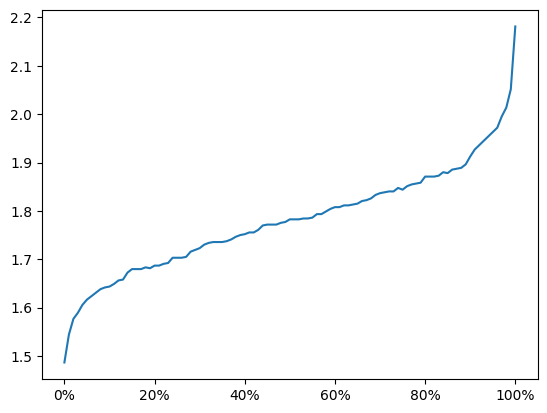

In [306]:
vlf_errors_df = calculate_errors_by_percentile(ds_vehicle_estimates_vlf['evsWithOnPlotParking'], ds_lad['EV Chargers'])
vlf_MAE_df = vlf_errors_df.abs()
vlf_MAE_df.mean(axis=1).plot()

<Axes: >

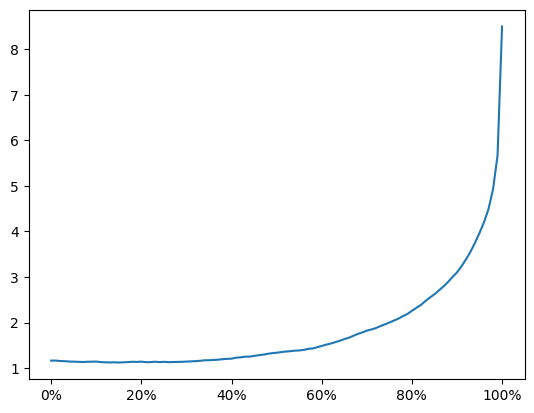

In [305]:
lf_errors_df = calculate_errors_by_percentile(ds_vehicle_estimates_lf['evsWithOnPlotParking'], ds_lad['EV Chargers'])
lf_MAE_df = lf_errors_df.abs()
lf_MAE_df.mean(axis=1).plot()

<Axes: >

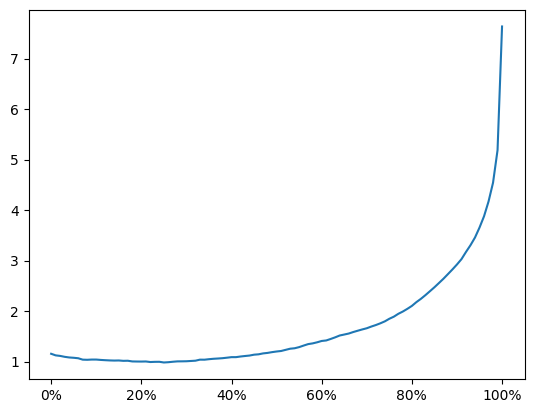

In [285]:
MAE_df.mean(axis=1).plot()

In [315]:
MAE_df.loc['50%'].mean()

1.1994584837545126

In [312]:
lf_MAE_df.loc['50%'].mean()

1.3375451263537905

In [313]:
vlf_MAE_df.loc['50%'].mean()

1.782490974729242

# Continuous Ranked Probability Score (CRPS)

In [121]:
import properscoring

In [123]:
ds_vehicle_estimates['evsWithOnPlotParking'].iloc[:, 0]

Quantile
0%       0
1%       0
2%       0
3%       0
4%       0
        ..
96%      9
97%     10
98%     11
99%     12
100%    15
Name: 110055, Length: 101, dtype: int64

In [196]:
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore
import statistics
from tqdm import tqdm

In [134]:
values = ds_vehicle_estimates['evsWithOnPlotParking'].iloc[:, 0].values
quantiles = np.arange(0, 1.01, 0.01)

In [135]:
cdf_function = interp1d(values, quantiles, bounds_error=False, fill_value=(0, 1))

In [149]:
cdf_function(1.2)

array(0.122)

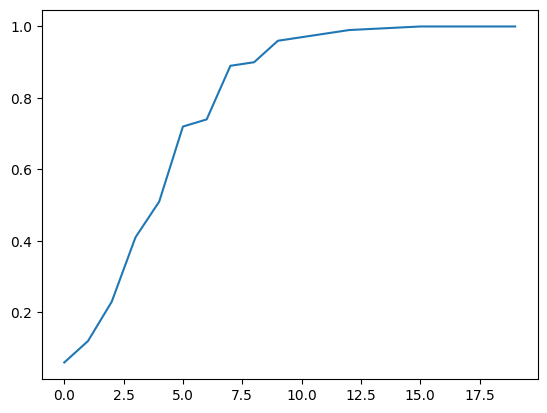

In [155]:
x=np.arange(0, 20, 1)
plt.plot(x, cdf_function(x))

In [159]:
ds_lad['EV Chargers'].iloc[0]

3.0

In [190]:
crps = properscoring.crps_quadrature(5, cdf_function, xmin=0, xmax=max(values), tol=100).item()
crps

0.6754999999152486

In [243]:
def calculate_crps(predictions, true_values):
    crps_list = []
    quantiles = np.arange(0, 1.01, 0.01)
    non_nan_idx = true_values[~true_values.isna()].index # This method doesn't deal with nans very well
    for ds in tqdm(predictions[non_nan_idx].columns, desc='Calculating CRPS'):
        values = predictions[ds].values
        cdf_function = interp1d(values, quantiles, bounds_error=False, fill_value=(0, 1))
        crps = properscoring.crps_quadrature(true_values.loc[ds], cdf_function, xmin=0, xmax=max(values), tol=10).item()
        crps_list.append(crps)
    return statistics.fmean(crps_list)

In [244]:
calculate_crps(ds_vehicle_estimates['evsWithOnPlotParking'], ds_lad['EV Chargers'])

Calculating CRPS: 100%|██████████| 1108/1108 [00:13<00:00, 80.02it/s]


0.8652541475003817

In [308]:
calculate_crps(ds_vehicle_estimates_lf['evsWithOnPlotParking'], ds_lad['EV Chargers'])

Calculating CRPS:   0%|          | 0/1108 [00:00<?, ?it/s]

Calculating CRPS: 100%|██████████| 1108/1108 [00:14<00:00, 78.16it/s] 


0.9419818997800099

In [307]:
calculate_crps(ds_vehicle_estimates_vlf['evsWithOnPlotParking'], ds_lad['EV Chargers'])

Calculating CRPS: 100%|██████████| 1108/1108 [00:01<00:00, 598.99it/s]


1.6894821299557456

# Creating some Maps

In [339]:
global_min = min(
    ds_lad['EV Chargers'].min(), 
    ds_vehicle_estimates['evsWithOnPlotParking'].loc['50%'].min(),
    ds_vehicle_estimates_lf['evsWithOnPlotParking'].loc['50%'].min(),
    ds_vehicle_estimates_vlf['evsWithOnPlotParking'].loc['50%'].min()
    )

global_max = max(
    ds_lad['EV Chargers'].max(), 
    ds_vehicle_estimates['evsWithOnPlotParking'].loc['50%'].max(),
    ds_vehicle_estimates_lf['evsWithOnPlotParking'].loc['50%'].max(),
    ds_vehicle_estimates_vlf['evsWithOnPlotParking'].loc['50%'].max()
    )

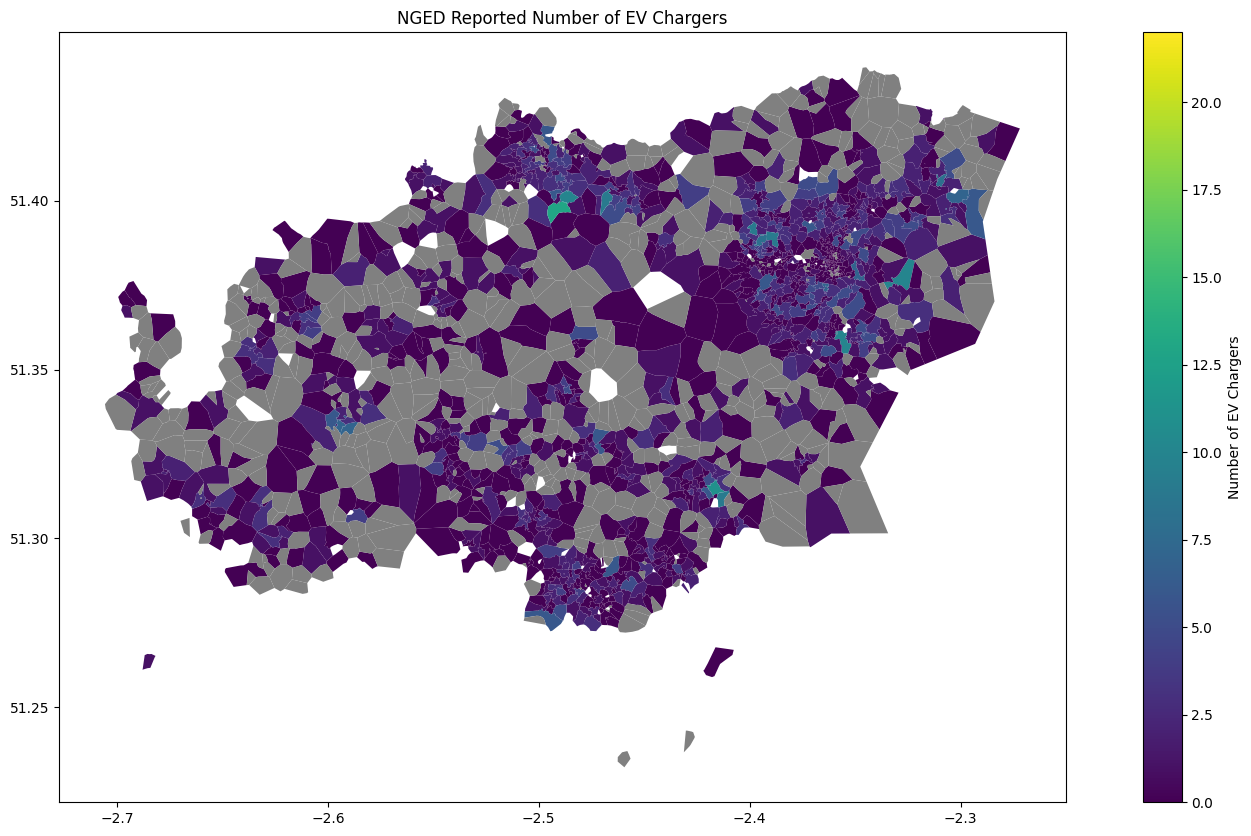

In [346]:
ds_lad.plot(
    column='EV Chargers',
    legend=True,
    figsize=[20,10],\
    legend_kwds={'label':'Number of EV Chargers'},
    missing_kwds= dict(color = "grey",),
    vmin=global_min,
    vmax=global_max,
)
plt.title('NGED Reported Number of EV Chargers')
plt.show()

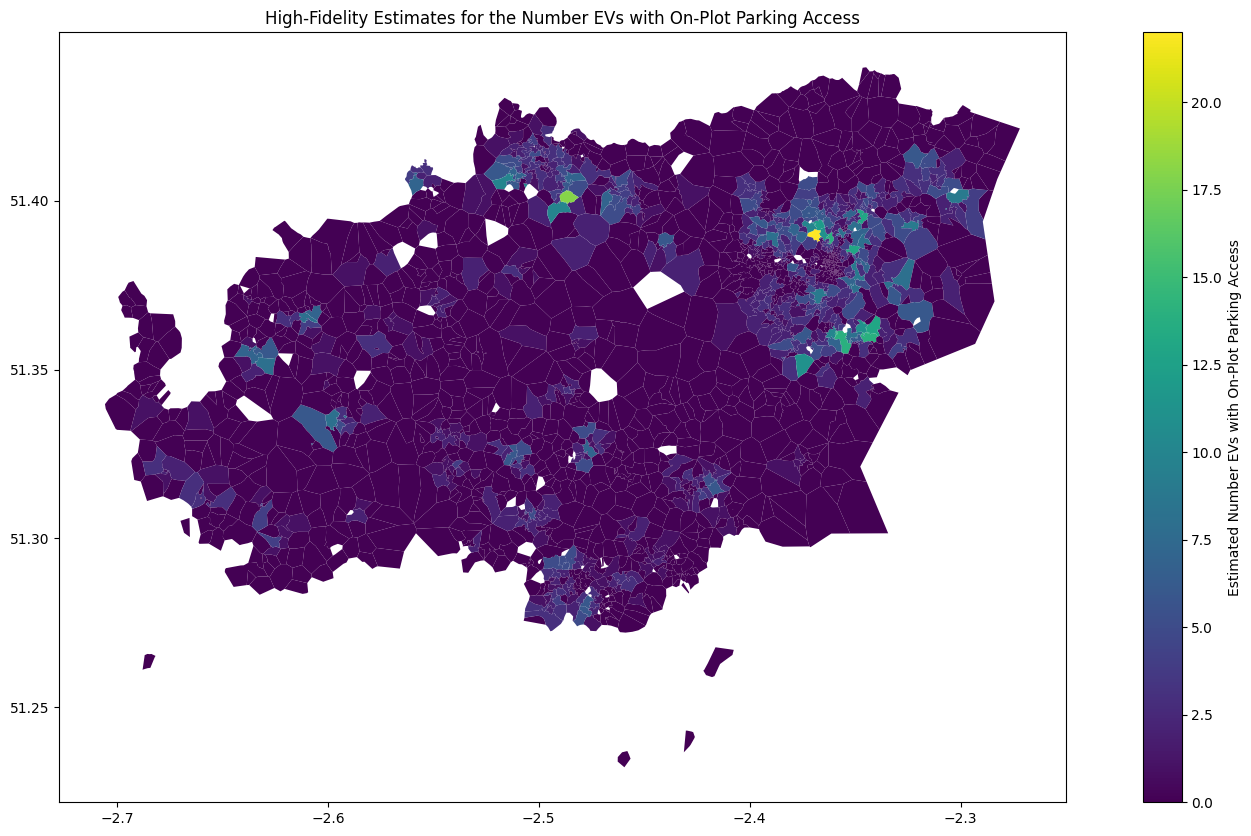

In [347]:
gpd.GeoDataFrame(data=ds_vehicle_estimates['evsWithOnPlotParking'].loc['50%'], geometry=ds_lad.geometry).plot(
    column='50%',
    legend=True,
    figsize=[20,10],\
    legend_kwds={'label':'Estimated Number EVs with On-Plot Parking Access'},
    missing_kwds= dict(color = "grey",),
    vmin=global_min,
    vmax=global_max
)
plt.title('High-Fidelity Estimates for the Number EVs with On-Plot Parking Access')
plt.show()

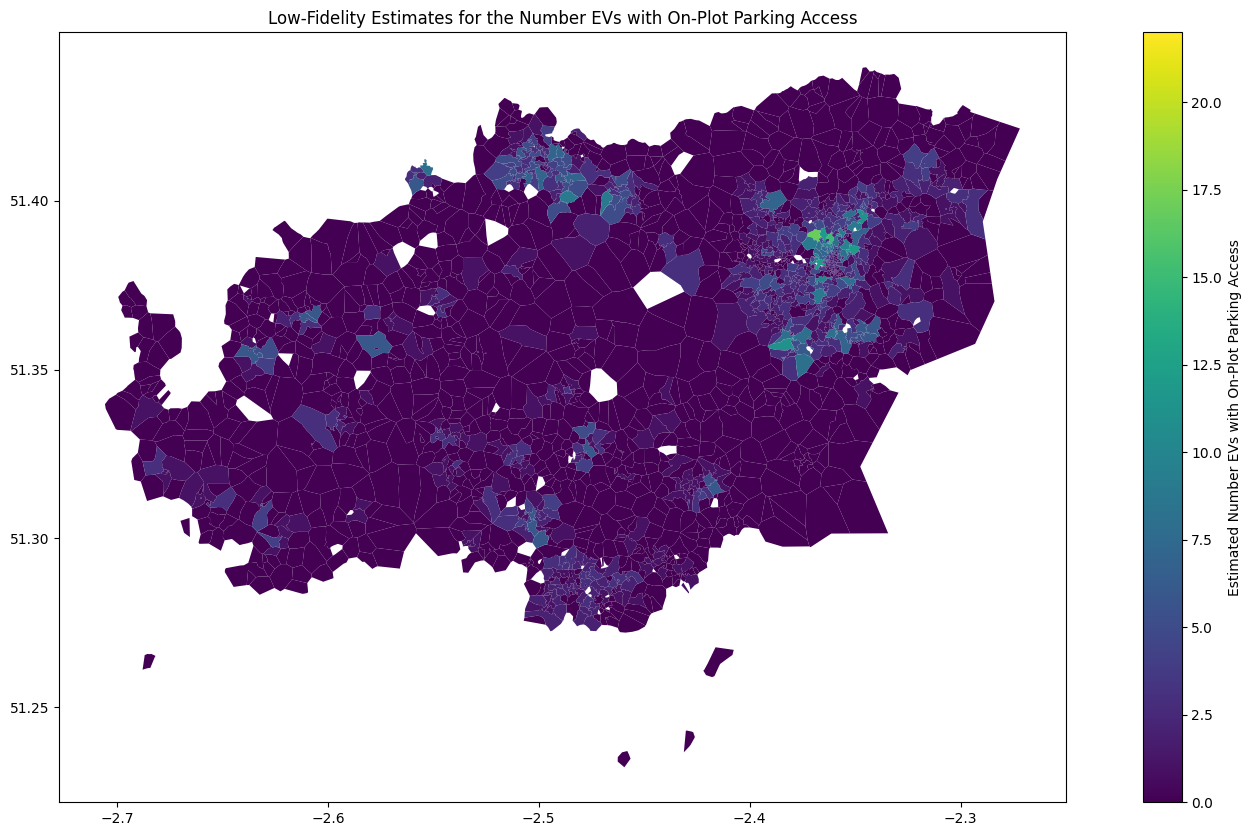

In [348]:
gpd.GeoDataFrame(data=ds_vehicle_estimates_lf['evsWithOnPlotParking'].loc['50%'], geometry=ds_lad.geometry).plot(
    column='50%',
    legend=True,
    figsize=[20,10],\
    legend_kwds={'label':'Estimated Number EVs with On-Plot Parking Access'},
    missing_kwds= dict(color = "grey",),
    vmin=global_min,
    vmax=global_max
)
plt.title('Low-Fidelity Estimates for the Number EVs with On-Plot Parking Access')
plt.show()

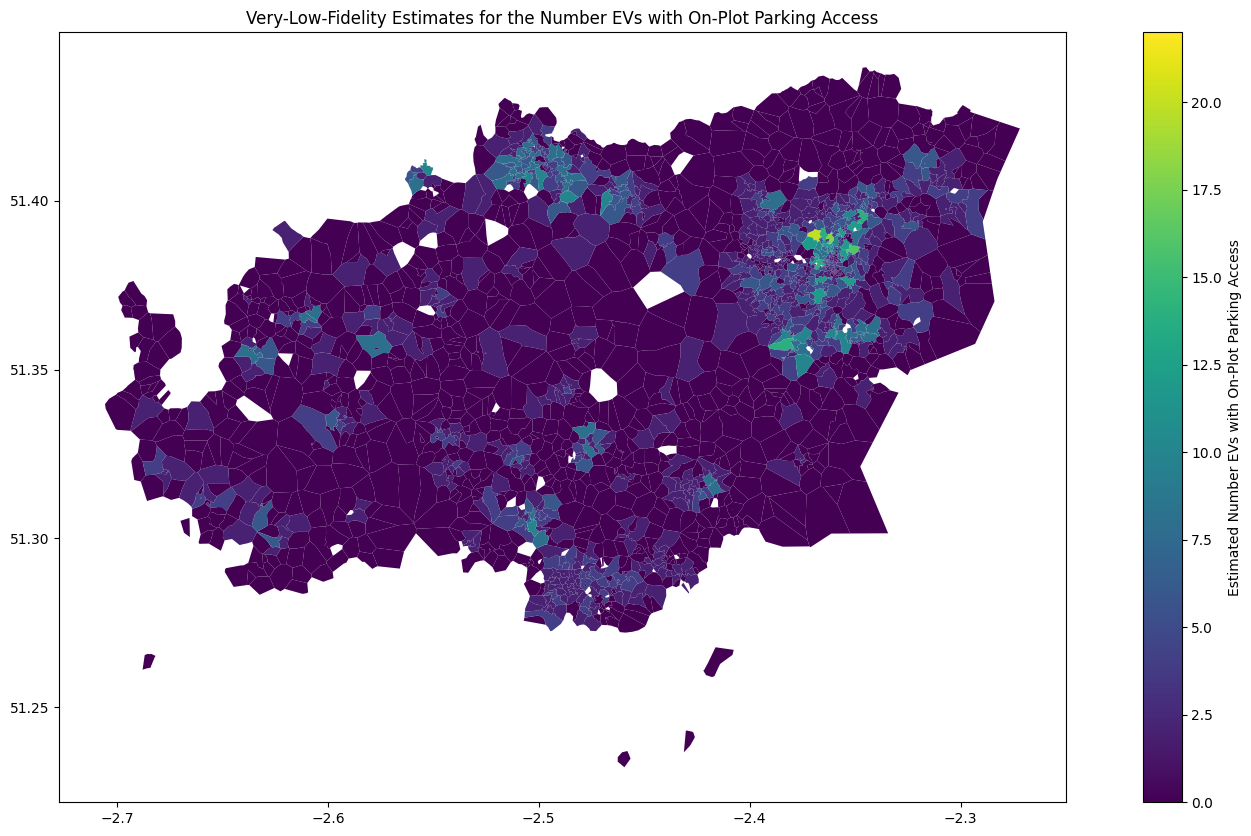

In [349]:
gpd.GeoDataFrame(data=ds_vehicle_estimates_vlf['evsWithOnPlotParking'].loc['50%'], geometry=ds_lad.geometry).plot(
    column='50%',
    legend=True,
    figsize=[20,10],\
    legend_kwds={'label':'Estimated Number EVs with On-Plot Parking Access'},
    missing_kwds= dict(color = "grey",),
    vmin=global_min,
    vmax=global_max
)
plt.title('Very-Low-Fidelity Estimates for the Number EVs with On-Plot Parking Access')
plt.show()

# Assessing Other Model Variations